# Comparison of McBEF vs Classic Biome Dependent Heat Fluxes

This notebook compares the inputs
* McBEF
* Classic Freitas PR model assumptions implemented in plumerise.bioma
Notice that flaming heatfluxes and the fraction of flaming/smoldering fires are prescribed as a function of biome type.

In [1]:
import os

#import importlib 
#importlib.reload(kde)

from IPython.display import display, Markdown

import numpy as np
import xarray as xr

from pyobs     import igbp, kde
from plumerise import bioma as bm

import matplotlib.pyplot as plt
%matplotlib inline 

lb, mode, ub = (0, 1, 2)  # indices for McBEF stats


## Load data

In [2]:
def getFiresMetOneDay(day,Verbose=False):
    """
    Ingests McBEF retrievals and sampled meteorology for one day.
    """
    
    
    l2_dirn = '/css/viirs/data/Level2/VNP47MCBEF/2019/'
    f_fname = l2_dirn + 'VNP47MCBEF.Stats.A2019%03d.0000_2400.Uniform_v_1_0_0.nc'%day
    #m_fname = l2_dirn + 'VNP47MCBEF.Met.A2019%03d.nc'%day
    
    f = xr.open_dataset(f_fname) # fire property statistics
    #m = xr.open_dataset(m_fname) # sample met fields
    
    if Verbose:
        display(Markdown("**FIRE PROPERTIES**"),f)
        display(Markdown("**SAMPLED METEOROLOGY**"),m)
    
    # Classic IGBP/INPE Vegetation Types used in QFED 2.x
    # ---------------------------------------------------
    v_dirn = '/discover/nobackup/projects/gmao/share/gmao_ops/qfed/Emissions/Vegetation/GL_IGBP_INPE/'
    bc = igbp.getSimpleVeg(f.FP_Longitude,f.FP_Latitude,Path=v_dirn)
    bd = igbp.getDetailedVeg(f.FP_Longitude,f.FP_Latitude,Path=v_dirn)
        
    # Biome Types using FILDA provided vegetation types
    # -------------------------------------------------
    bf = bm.getAggregateBiome ( f.FP_Land_Type, f.FP_Latitude)
                                 
    # Classic (biome-dependent heat fluxes)
    # ------------------------------------
    (cPower_f, cPower_s, cHeatFlux_f, cArea_f) = bm.getHeatFlux ( bf, f.Power[:,mode] ) # using FILDA biome type
                                              
                           
    return (f, bc, bd, bf, cPower_f, cPower_s, cHeatFlux_f, cArea_f)
                           
                           

In [3]:
# Loop over days...
n = 0
for day in [220,]:
    
    # Load fires and met fields
    # -------------------------
   (f, bc, bd, bf, cPower_f, cPower_s, cHeatFlux_f, cArea_f)  = getFiresMetOneDay(day,Verbose=False)
    


## Compare biome determination: IBGP/INPE vs MODIS Land Type

Classic Aggregated Biome Type yield:  22507 out of 22873   1 %
FILDA   Aggregated Biome Type yield:  22654 out of 22873   0 %


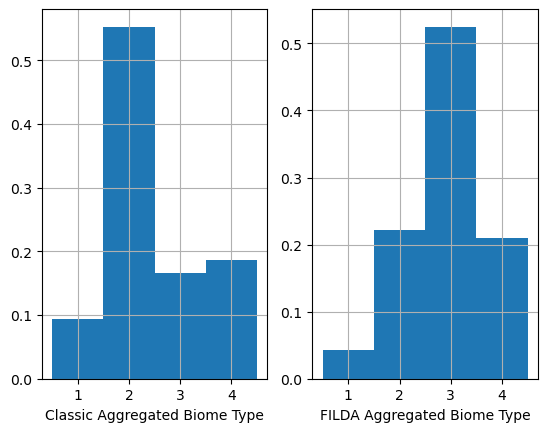

In [4]:
I = bc>0
plt.subplot(121)
plt.hist(bc[I],bins=(0.5,1.5,2.5,3.5,4.5),density=True)
plt.grid(), plt.xlabel('Classic Aggregated Biome Type')
print('Classic Aggregated Biome Type yield: ',bc[I].size,'out of',bc.size,'%3d %%'%int(100*(bc.size-bc[I].size)/bc.size))

I = bf>0
plt.subplot(122)
plt.hist(bf[I],bins=(0.5,1.5,2.5,3.5,4.5),density=True)
plt.grid(), plt.xlabel('FILDA Aggregated Biome Type')
print('FILDA   Aggregated Biome Type yield: ',bf[I].size,'out of',bf.size,'%3d %%'%int(100*(bf.size-bf[I].size)/bf.size))

(None,
 Text(0.5, 1.0, 'Classic Aggregated Biome'))

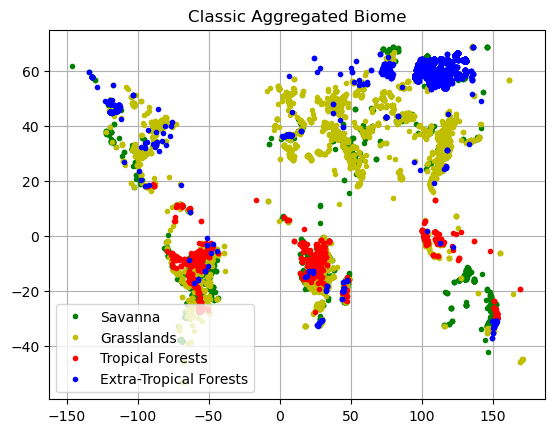

In [5]:
b = bc
plt.plot(f.FP_Longitude[b==3],f.FP_Latitude[b==3],'g.',label='Savanna')
plt.plot(f.FP_Longitude[b==4],f.FP_Latitude[b==4],'y.',label='Grasslands')
plt.plot(f.FP_Longitude[b==1],f.FP_Latitude[b==1],'r.',label='Tropical Forests')
plt.plot(f.FP_Longitude[b==2],f.FP_Latitude[b==2],'b.',label='Extra-Tropical Forests')
plt.grid(),plt.legend(),plt.title('Classic Aggregated Biome')

(None,
 Text(0.5, 1.0, 'FILDA Aggregated Biome'))

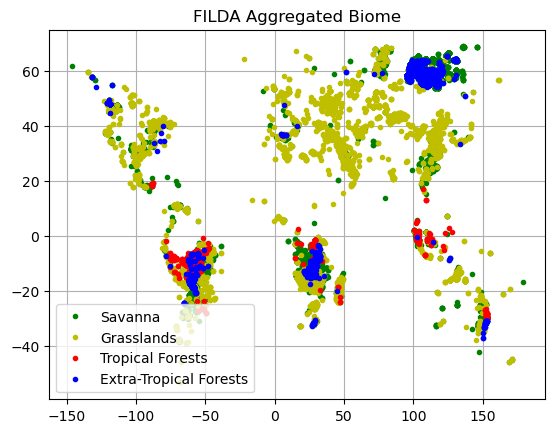

In [6]:
b = bf
plt.plot(f.FP_Longitude[b==3],f.FP_Latitude[b==3],'g.',label='Savanna')
plt.plot(f.FP_Longitude[b==4],f.FP_Latitude[b==4],'y.',label='Grasslands')
plt.plot(f.FP_Longitude[b==1],f.FP_Latitude[b==1],'r.',label='Tropical Forests')
plt.plot(f.FP_Longitude[b==2],f.FP_Latitude[b==2],'b.',label='Extra-Tropical Forests')
plt.grid(),plt.legend(),plt.title('FILDA Aggregated Biome')

Classic   Detailed Biome Type yield:  22873 out of 22873   0 %


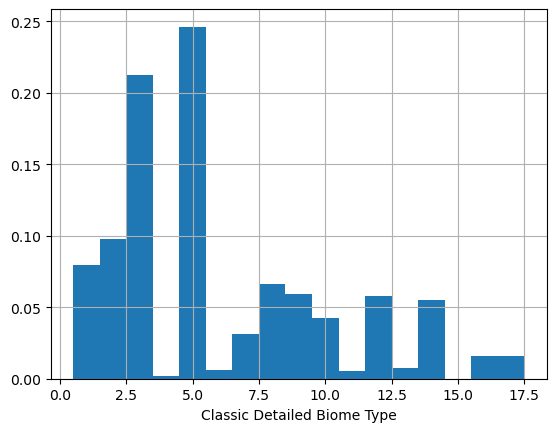

In [7]:
b = bd
I = (b>0)&(b<18)
plt.hist(b[I],bins=np.arange(0.5,18.5,1),density=True)
plt.grid(), plt.xlabel('Classic Detailed Biome Type')
print('Classic   Detailed Biome Type yield: ',b[I].size,'out of',b.size,'%3d %%'%int(100*(b.size-b[I].size)/b.size))

FILDA   Detailed Biome Type yield:  22867 out of 22873   0 %


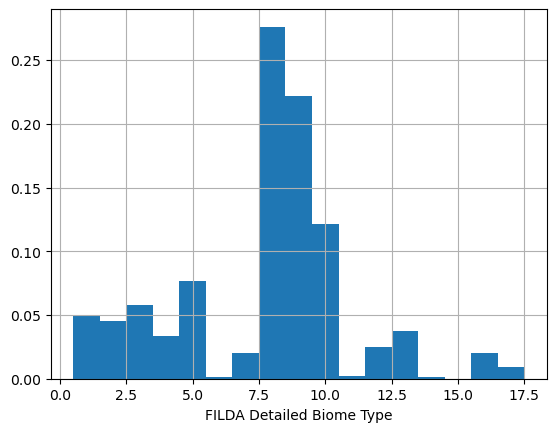

In [8]:
b = f.FP_Land_Type
I = (b>0)&(b<18)
plt.hist(b[I],bins=np.arange(0.5,18.5,1),density=True)
plt.grid(), plt.xlabel('FILDA Detailed Biome Type')
print('FILDA   Detailed Biome Type yield: ',b[I].size,'out of',b.size,'%3d %%'%int(100*(b.size-b[I].size)/b.size))

## Comparing Heat Fluxes by Aggregated Biome
Given the general agreement above, we will use the aggregated bioma consistent with the FILDA/MODIS land types.

In [9]:
b = bf

### Tropical Forests

In [10]:
def plot_HF(biome,title,xlabel,range=None):

    I = (b==biome)&(np.isnan(f.HeatFlux_f[:,1])==False)
    bins, PF0 = kde.calc_kde1d(1000*f.HeatFlux_f[I,0],range=range)
    bins, PF1 = kde.calc_kde1d(1000*f.HeatFlux_f[I,1],range=range)
    bins, PF2 = kde.calc_kde1d(1000*f.HeatFlux_f[I,2],range=range)

    cmin = bm.HEAT_FLUX_MIN[biome-1]
    cmax = bm.HEAT_FLUX_MAX[biome-1]
    cmod = (cmin+cmax)/2
    
    pmax = PF0.max()

    plt.plot(bins,PF0,'b--',label='McBEF (lower)')
    plt.plot(bins,PF1,'b', label='McBEF (mode)')
    plt.plot(bins,PF2,'b--',label='McBEF (upper)')
    
    plt.plot([cmin,cmin],[0,pmax],'r--',label='Classic (lower)')
    plt.plot([cmod,cmod],[0,pmax],'r',  label='Classic (mode)')
    plt.plot([cmax,cmax],[0,pmax],'r--',label='Classic (upper)')
    
    plt.grid(), plt.xlabel(xlabel),plt.ylabel('p.d.f'),plt.title(title)
    plt.legend(loc='upper right')

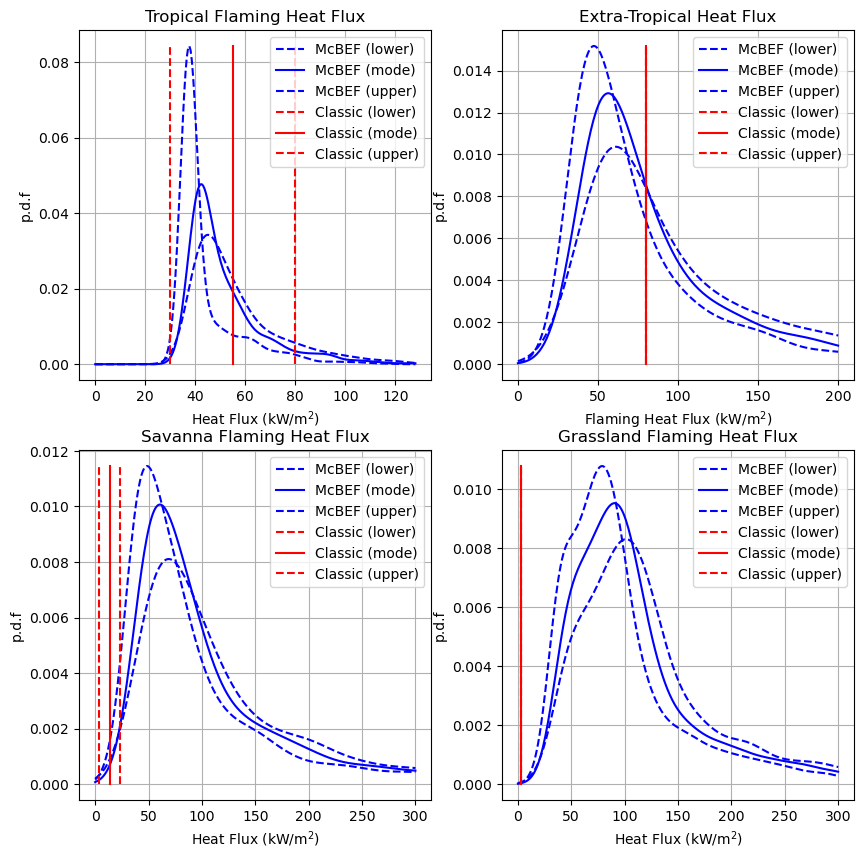

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_HF(bm.TROPICAL,'Tropical Flaming Heat Flux', r'Heat Flux (kW/m$^2$)',range=(0,128))
plt.subplot(222)
plot_HF(bm.EXTRA_TROPICAL,'Extra-Tropical Heat Flux', r'Flaming Heat Flux (kW/m$^2$)',range=(0,200))
plt.subplot(223)
plot_HF(bm.SAVANNA,'Savanna Flaming Heat Flux', r'Heat Flux (kW/m$^2$)',range=(0,300))
plt.subplot(224)
plot_HF(bm.GRASSLAND,'Grassland Flaming Heat Flux', r'Heat Flux (kW/m$^2$)',range=(0,300))

In [12]:
def plot_Prop(biome,X,C,title,xlabel,range=None):

    I = (b==biome)&(np.isnan(X[:,1])==False)
    bins, X0 = kde.calc_kde1d(X[I,0],range=range)
    bins, X1 = kde.calc_kde1d(X[I,1],range=range)
    bins, X2 = kde.calc_kde1d(X[I,2],range=range)

    if len(C.shape) == 2:
        J = (b==biome)&(np.isnan(C[:,1])==False)
        bins, C0 = kde.calc_kde1d(C[J,0],range=range)
        bins, C1 = kde.calc_kde1d(C[J,1],range=range)
        bins, C2 = kde.calc_kde1d(C[J,2],range=range)
    else:
        J = (b==biome)&(np.isnan(C)==False)
        bins, C0 = kde.calc_kde1d(C[J],range=range)

    plt.plot(bins,X0,'b--',label='McBEF (lower)')
    plt.plot(bins,X1,'b',  label='McBEF (mode)')
    plt.plot(bins,X2,'b--',label='McBEF (upper)')
    
    if len(C.shape) == 2:                    
        plt.plot(bins,C0,'r--',label='Classic (lower)')
        plt.plot(bins,C1,'r',  label='Classic (mode)')
        plt.plot(bins,C2,'r--',label='Classic (upper)')
    else:
        plt.plot(bins,C0,'r',  label='Classic')                

    plt.grid(), plt.xlabel(xlabel),plt.ylabel('p.d.f'),plt.title(title)
    plt.legend(loc='upper right')

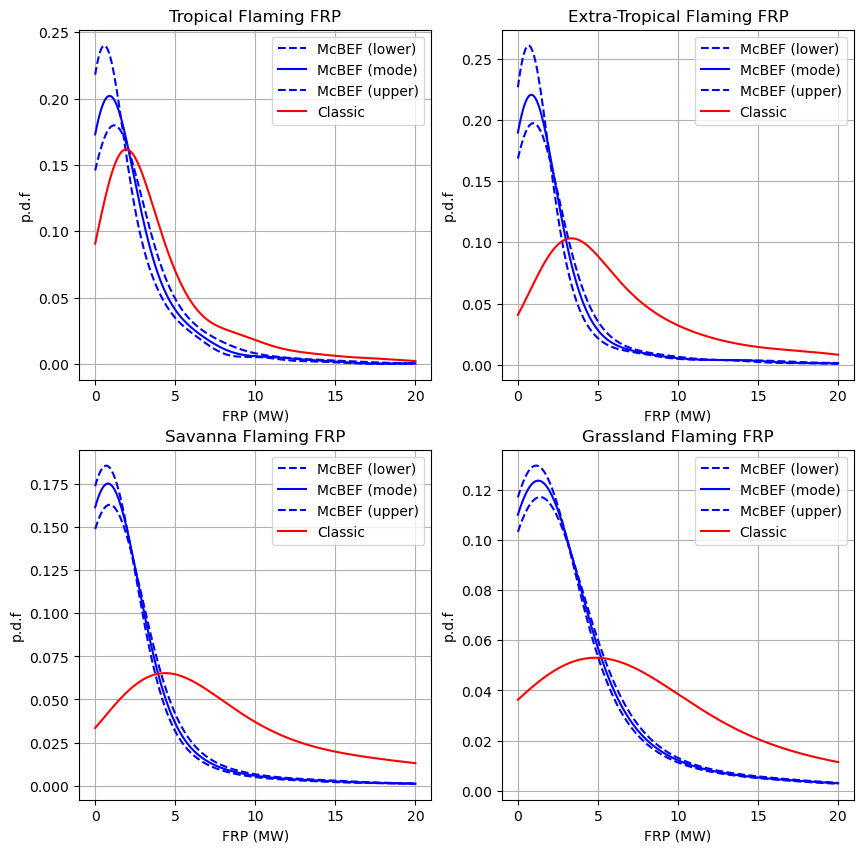

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Prop(bm.TROPICAL,f.Power_f,cPower_f,'Tropical Flaming FRP', 'FRP (MW)',range=(0,20))
plt.subplot(222)
plot_Prop(bm.EXTRA_TROPICAL,f.Power_f,cPower_f,'Extra-Tropical Flaming FRP', 'FRP (MW)',range=(0,20))
plt.subplot(223)
plot_Prop(bm.SAVANNA,f.Power_f,cPower_f,'Savanna Flaming FRP', 'FRP (MW)',range=(0,20))
plt.subplot(224)
plot_Prop(bm.GRASSLAND,f.Power_f,cPower_f,'Grassland Flaming FRP', 'FRP (MW)',range=(0,20))

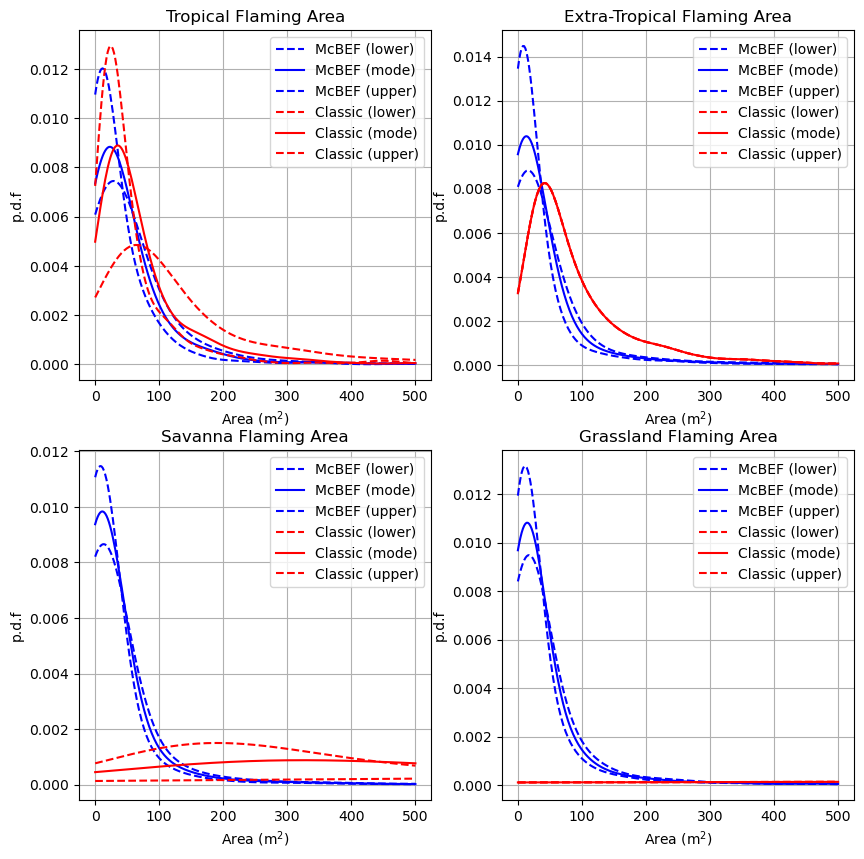

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Prop(bm.TROPICAL,f.Area_f,cArea_f,'Tropical Flaming Area',  'Area (m$^2$)',range=(0,500))
plt.subplot(222)
plot_Prop(bm.EXTRA_TROPICAL,f.Area_f,cArea_f,'Extra-Tropical Flaming Area', 'Area (m$^2$)',range=(0,500))
plt.subplot(223)
plot_Prop(bm.SAVANNA,f.Area_f,cArea_f,'Savanna Flaming Area', 'Area (m$^2$)',range=(0,500))
plt.subplot(224)
plot_Prop(bm.GRASSLAND,f.Area_f,cArea_f,'Grassland Flaming Area', 'Area (m$^2$)',range=(0,500))

In [15]:
f

<xarray.Dataset>
Dimensions:         (fire: 22873, stat: 5)
Coordinates:
    FP_Latitude     (fire) float32 -30.1 -30.11 -30.16 ... -32.96 -32.98 -32.98
    FP_Longitude    (fire) float32 29.1 28.64 29.56 29.89 ... 18.05 18.03 18.02
    FP_Time         (fire) datetime64[ns] ...
Dimensions without coordinates: fire, stat
Data variables: (12/30)
    crs             int64 ...
    t_b             (fire) float32 ...
    C               (fire) float32 ...
    QA_flag         (fire) uint32 ...
    FP_Power_R_AC   (fire) float32 ...
    FP_confidence   (fire) int8 ...
    ...              ...
    t_f             (fire, stat) float32 ...
    t_s             (fire, stat) float32 ...
    p_s             (fire, stat) float32 ...
    p_f             (fire, stat) float32 ...
    Area_s          (fire, stat) float32 ...
    Area_f          (fire, stat) float32 ...
Attributes: (12/40)
    history:             Created Sun Nov 17 02:57:53 2024 main_reprocessing.py
    LongName:            MCBEF fire parameter estimation on FILDA VNP47MOD.
    satellite:           VNP
    sel_bg_bands:        ['M14', 'M15', 'I05', 'M16']
    sel_fire_bands:      ['DNB', 'M11', 'M13', 'M14', 'M15', 'M16']
    num_draw:            500
    ...                  ...
    sigma_C:             0.5
    thd_frp:             0.0
    frp_sigma_scale:     0.2
    SNR_bg:              {'DNB': 6.0, 'M08': 20.0, 'M10': 20.0, 'M11': 30.0, ...
    SNR_fire:            {'DNB': 6.0, 'M08': 20.0, 'M10': 40.0, 'M11': 60.0, ...
    precompile_string:   ,compiledir_mode=readonly